# Вокодер - реализация принципиальной схемы

Принципильная схема вокодера выглядит так(по моему скромному мнению):

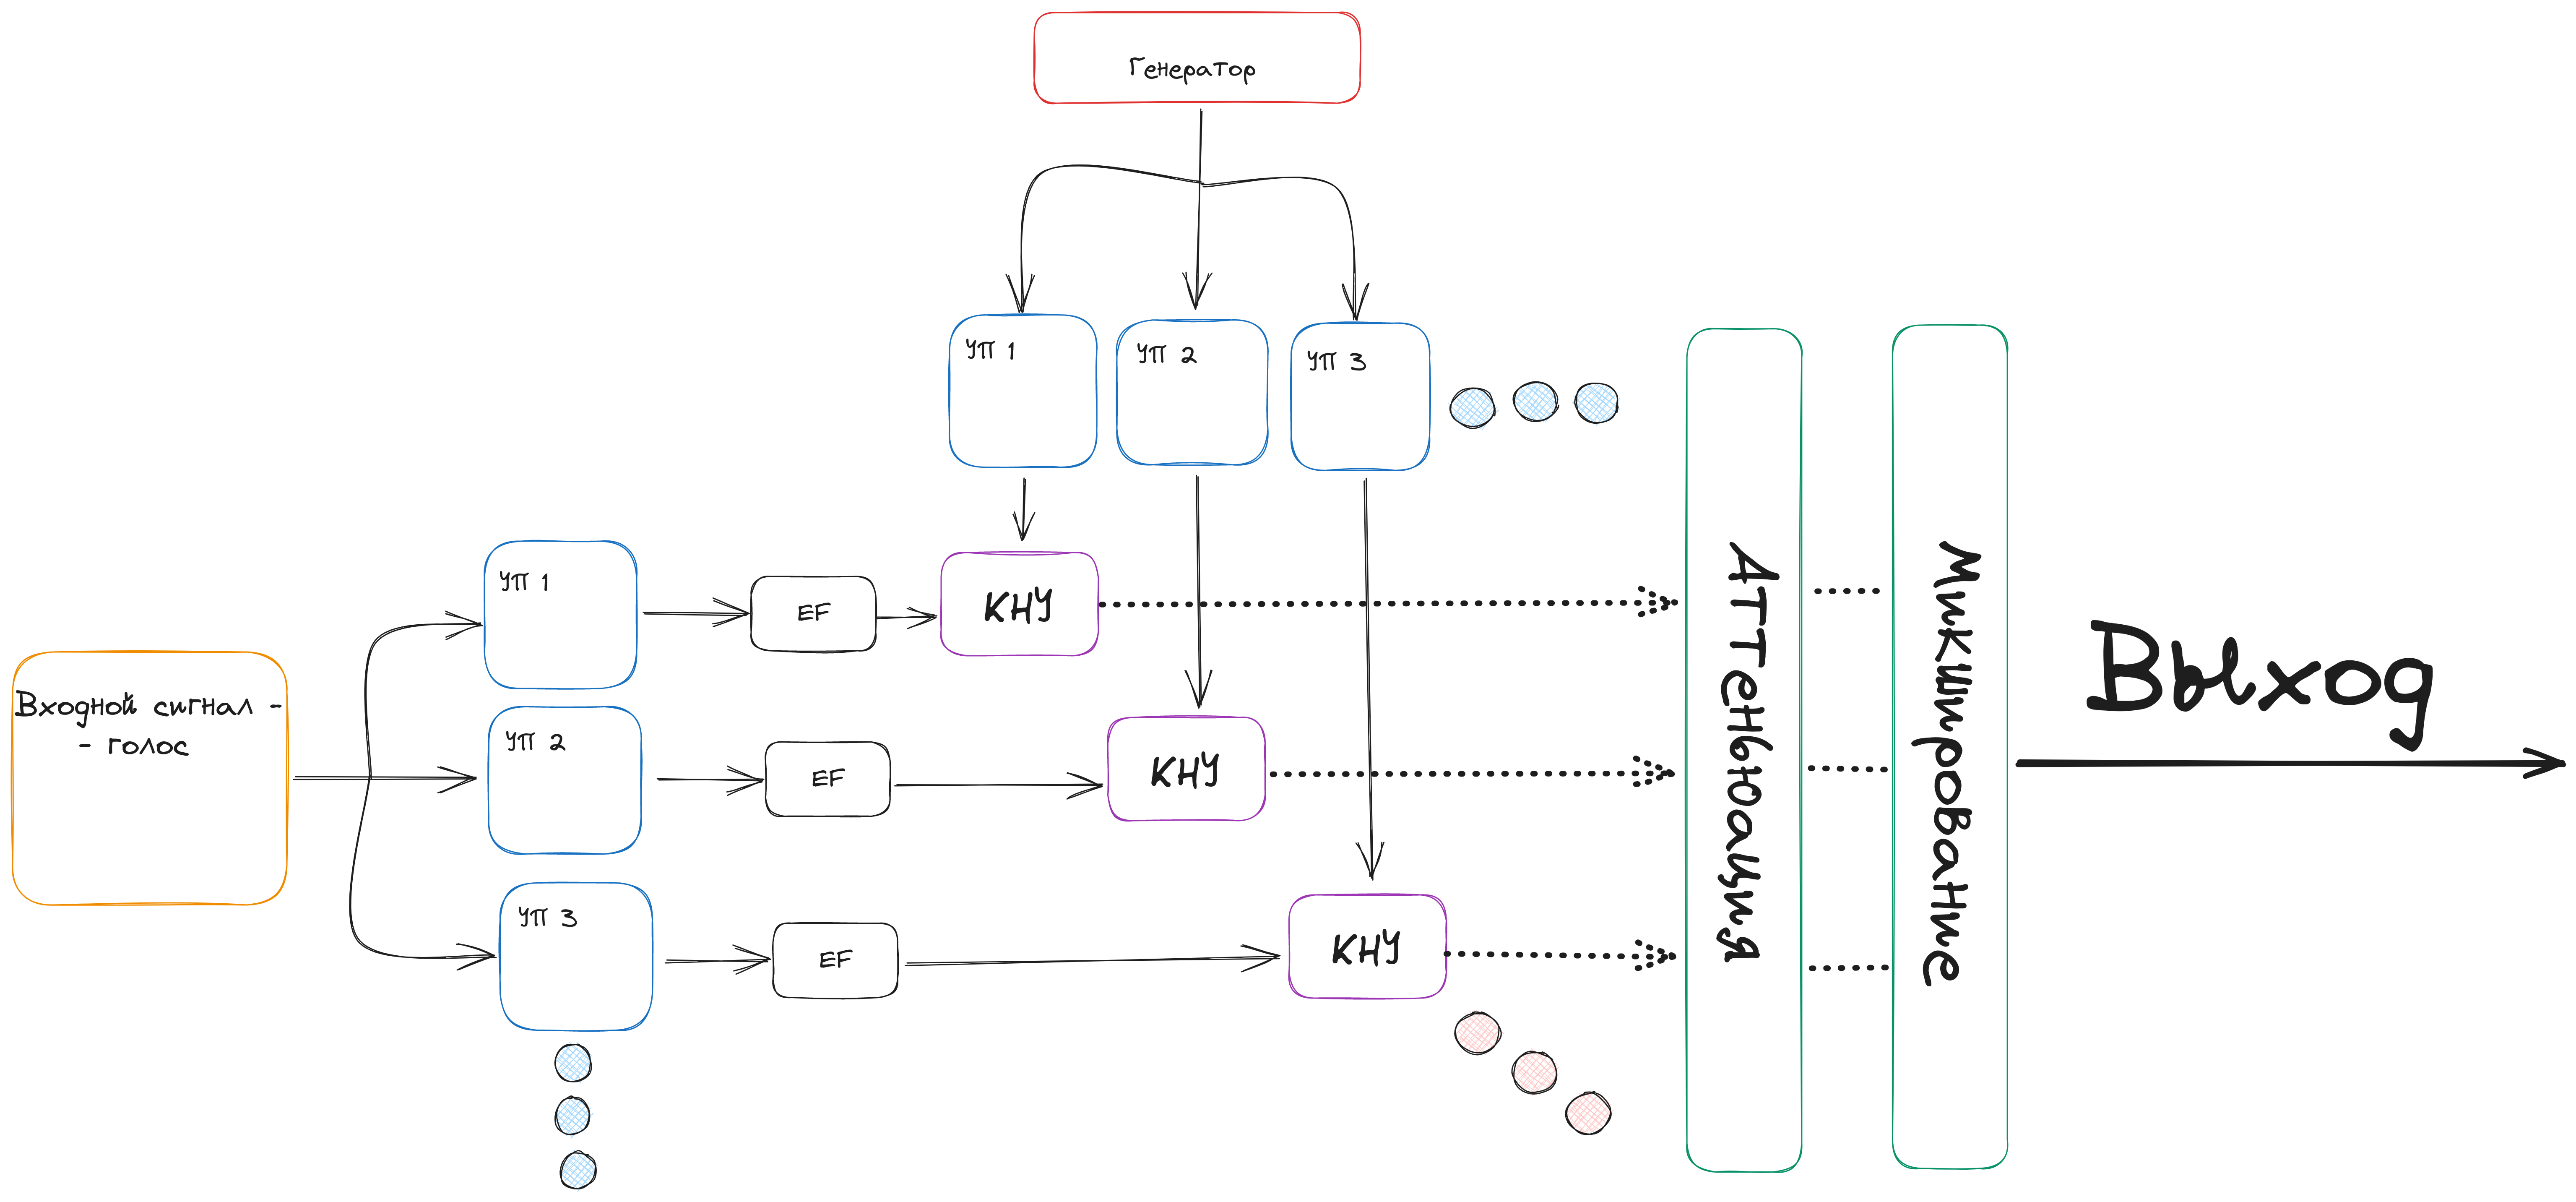

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from IPython import display
from matplotlib import cm

max_amplitude = np.iinfo(np.int16).max

Загрузим исходный файл для теста 

In [94]:
filepath = r"nana.wav"
display.Audio(filepath)

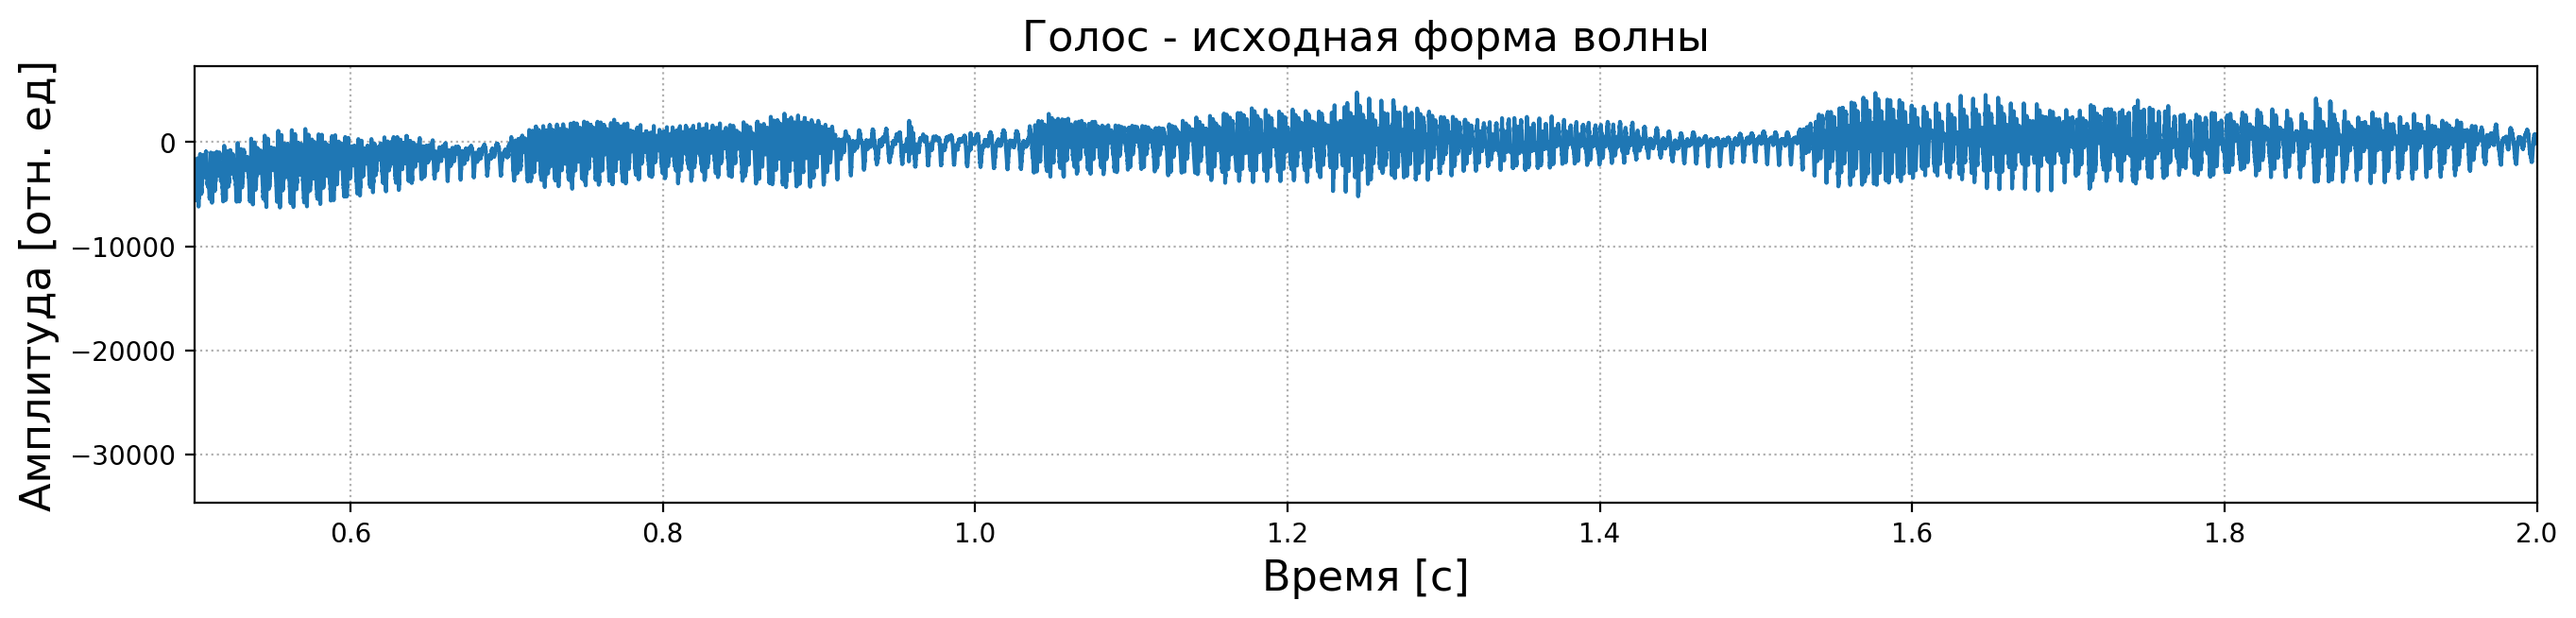

In [95]:
sample_rate, voice = wavfile.read(filepath)
voice = voice[:, 0]
time = np.linspace(0, voice.shape[0] / sample_rate, voice.shape[0])
left_lim, right_lim = 0.5, 2

plt.figure(figsize = (16, 3), dpi = 200)
plt.plot(time, voice)
plt.xlim(left_lim, right_lim)
plt.xlabel("Время [c]", fontsize = 16)
plt.ylabel("Амплитуда [отн. ед]", fontsize = 16)
plt.title("Голос - исходная форма волны", fontsize = 16)
plt.grid(ls = ':')

### Стадия один - цепочка фильтров узкой полосы

In [96]:
min_freq, max_freq, filter_q = 30, 1000, 15
center_freqs = np.linspace(min_freq, max_freq, filter_q)
bp_slope = 20
bp_filters = [signal.butter(4, Wn = [freq - bp_slope, freq + bp_slope], btype = 'bp', analog = False, fs = 10000, output = 'sos') for freq in center_freqs]
filtered_signals = [signal.sosfilt(bp_filters[i], voice) for i in range(len(center_freqs))]
filtered_signals_envelope = [np.abs(signal.hilbert(sig)) for sig in filtered_signals]

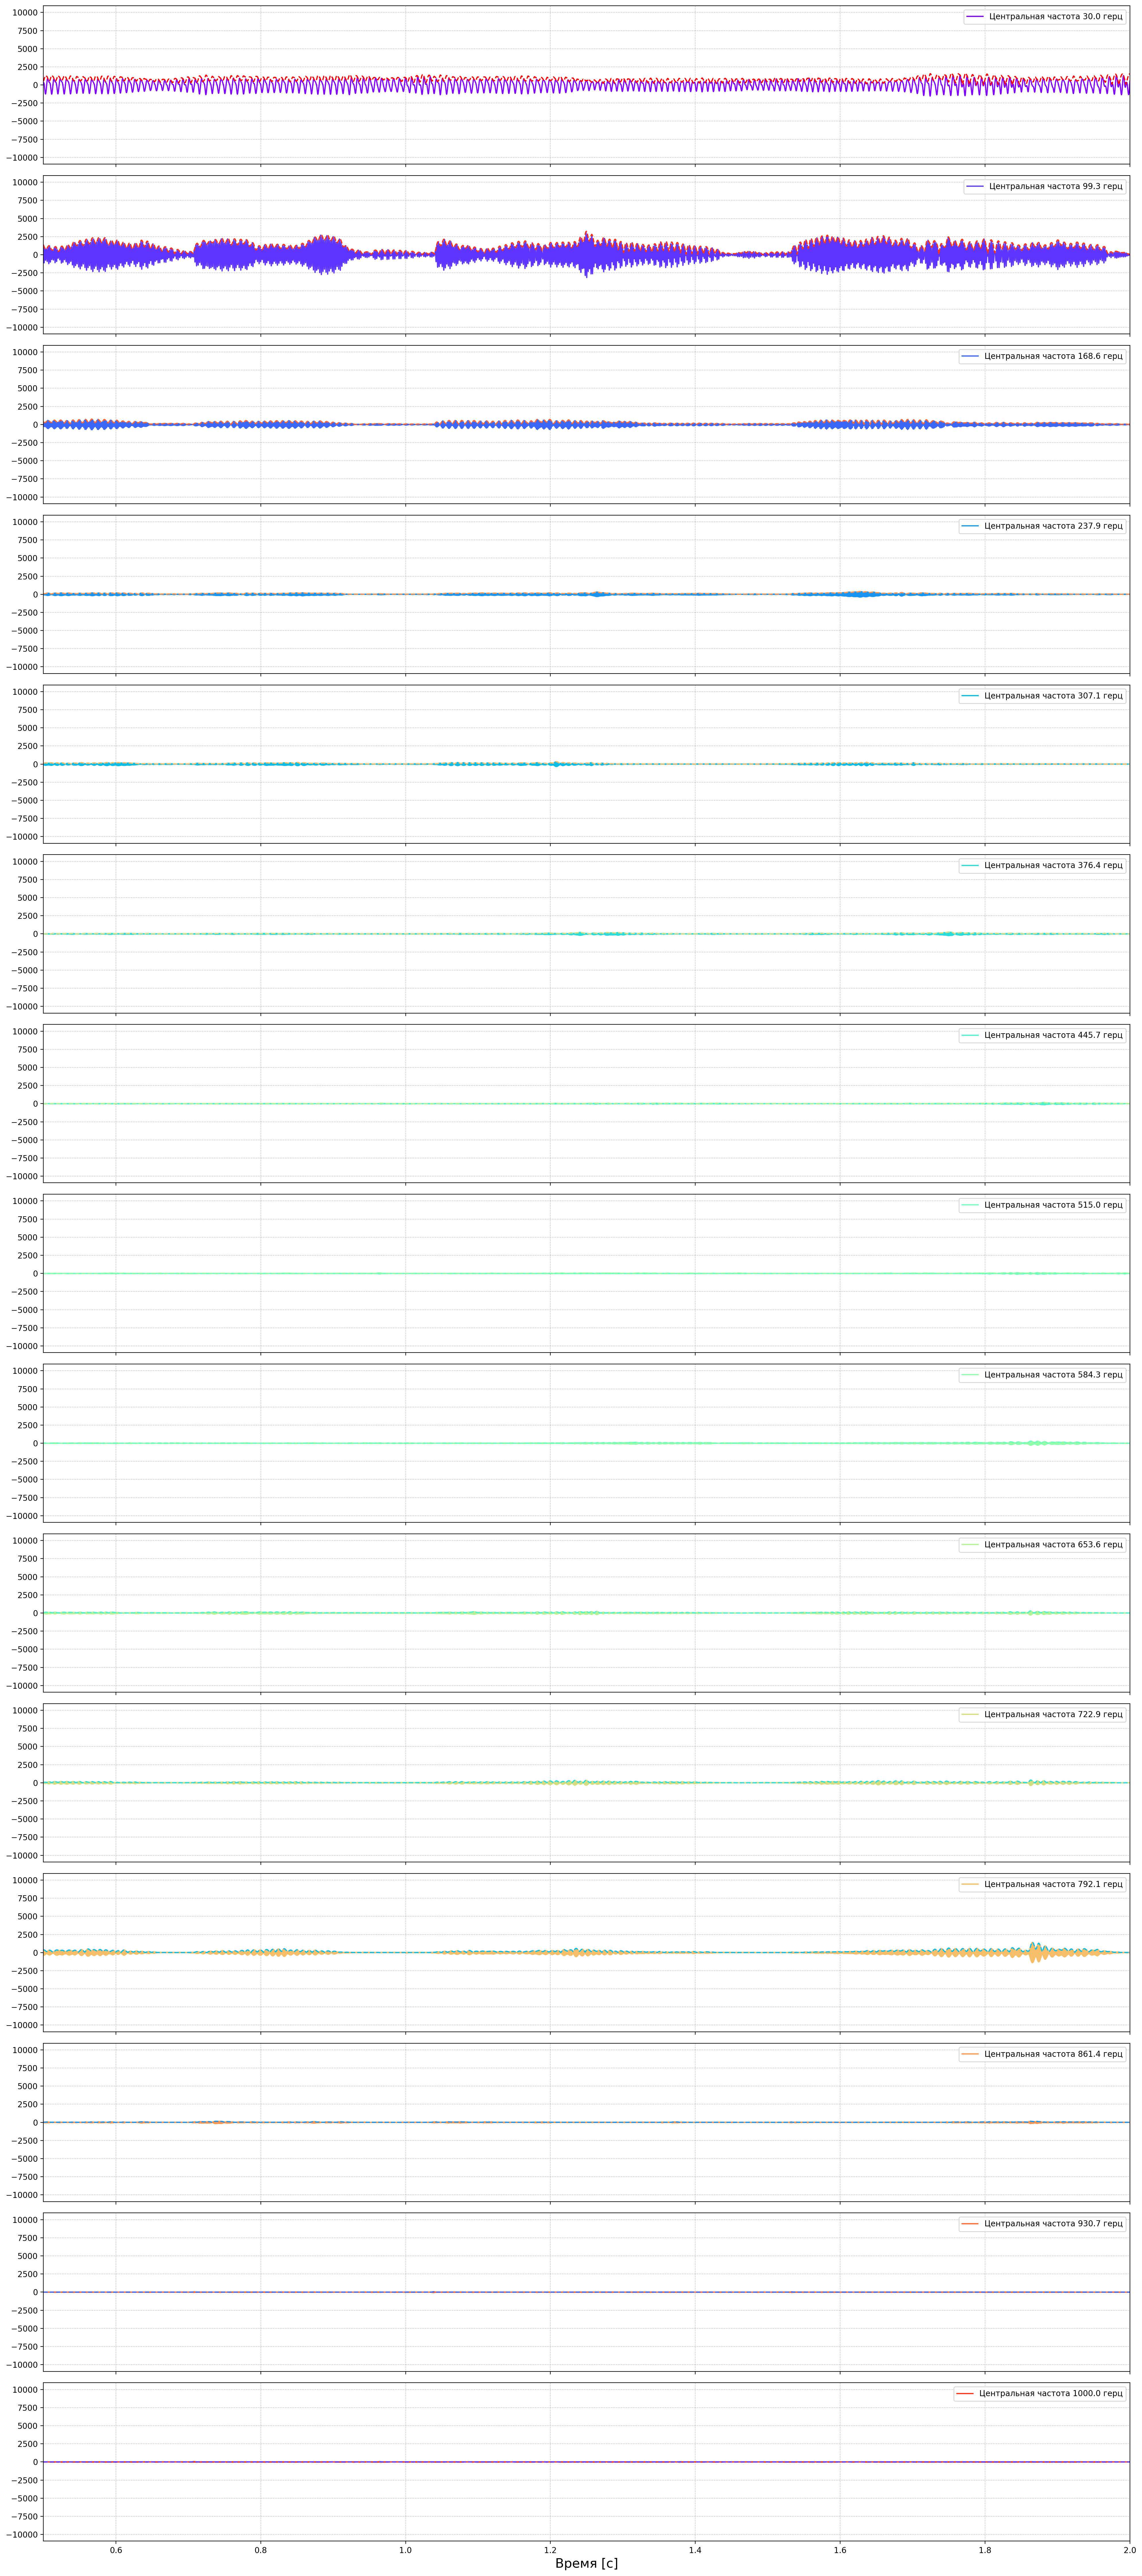

In [97]:
fig, ax = plt.subplots(len(center_freqs), 1, figsize = (20, 3 * len(center_freqs)), dpi = 200, sharex = True)

for ind, (sig, plotable, cutoff, envelope) in enumerate(zip(filtered_signals, ax, center_freqs, filtered_signals_envelope)):
    plotable.plot(time, 
                  sig, 
                  color = cm.rainbow(ind / len(center_freqs)),
                  label = f'Центральная частота {cutoff:.1f} герц')
    plotable.set_xlim(left_lim, right_lim)
    plotable.legend()
    plotable.plot(time, 
                  envelope, 
                  '--',
                  color = cm.rainbow(1 - ind / len(center_freqs)),
                  label = 'Огибающая')
    plotable.grid(ls = ':')
    plotable.set_ylim(-max_amplitude / 3, max_amplitude / 3)


ax[-1].set_xlabel("Время [c]", fontsize = 16)
fig.tight_layout()

### Пропуск основного сигнала через цепочку фильтров. Применение найденных огибающих

Создадим <<несущий>> сигнал смешав несколько пилообразных осцилляторов. Частоты осцилляторов укажем в массиве `osc_frequencies`.

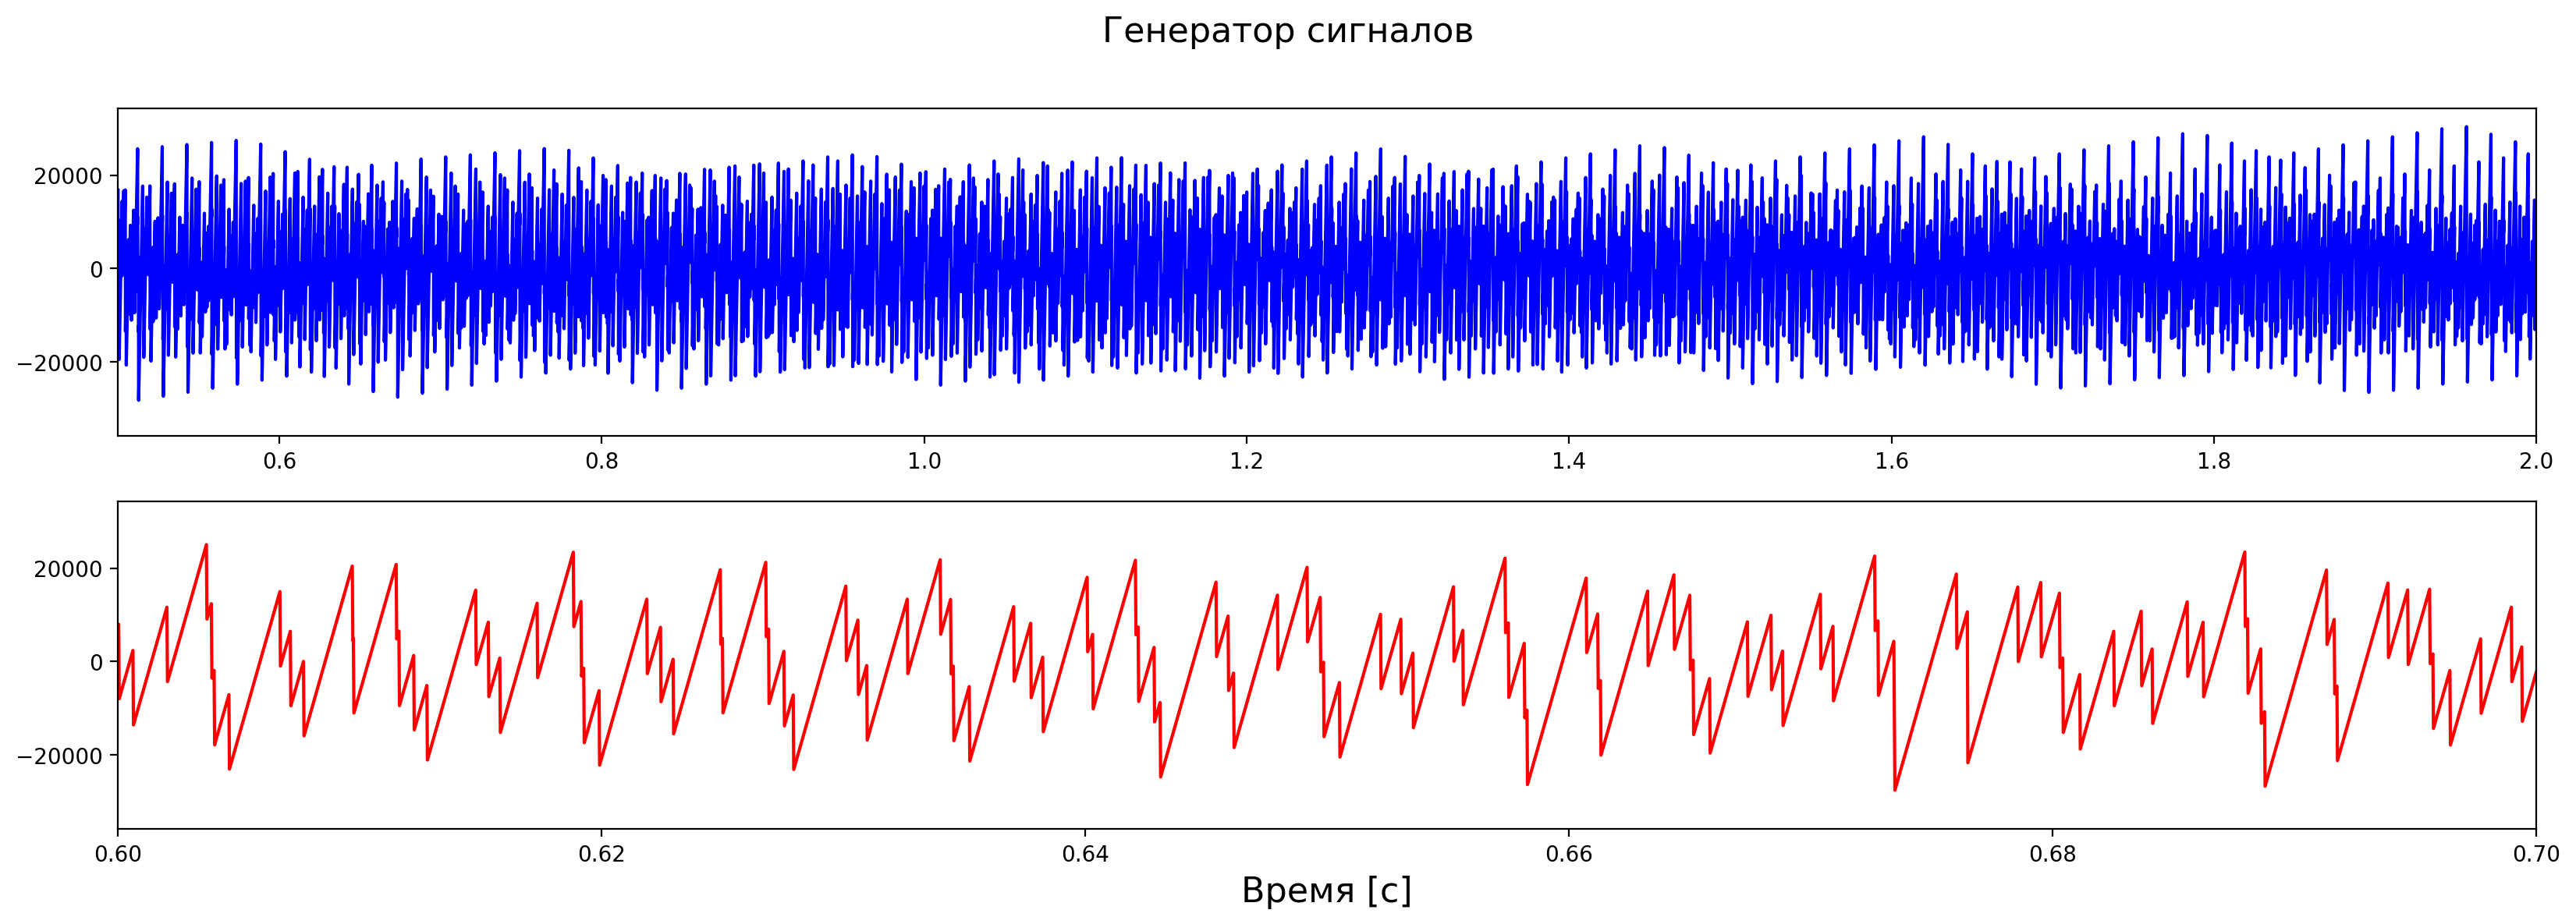

In [98]:
amplitude_osc = max_amplitude
osc_frequencies = [130.8, 523.3 / 2, 659.3 / 2, 784 / 2] # аккорд до-мажор + нота до на две октавы ниже
osc_amp_ratios = [1, 1 / 2, 1 / 2, 1 / 2]
oscillators = np.array([signal.sawtooth(2 * np.pi * freq * time) for amp, freq in zip(osc_amp_ratios, osc_frequencies)])
osc_sum = amplitude_osc * np.sum(oscillators, axis = 0) / len(osc_frequencies)

fig, ax = plt.subplots(2, 1, figsize = (20, 6), dpi = 200)
ax[0].plot(time, osc_sum, color = 'blue')
ax[1].plot(time, osc_sum, color = 'red')
ax[1].set_xlim(0.6, 0.7)
ax[0].set_xlim(left_lim, right_lim)
ax[1].set_xlabel("Время [c]", fontsize = 16)
fig.suptitle("Генератор сигналов", fontsize = 16);

In [99]:
wavfile.write("generator_signal.wav", sample_rate, osc_sum.astype(np.int16))

In [100]:
display.Audio(r"generator_signal.wav")

Пропустим сигнал через фильтры и применим амплитудную огибающую

In [101]:
carrier_filtered = [signal.sosfilt(bp_filters[i], osc_sum) for i in range(len(center_freqs))]
carrier_filtered_amplifiered = [sig * env / amplitude_osc for env, sig in zip(filtered_signals_envelope, carrier_filtered)]
result = sum(carrier_filtered_amplifiered)

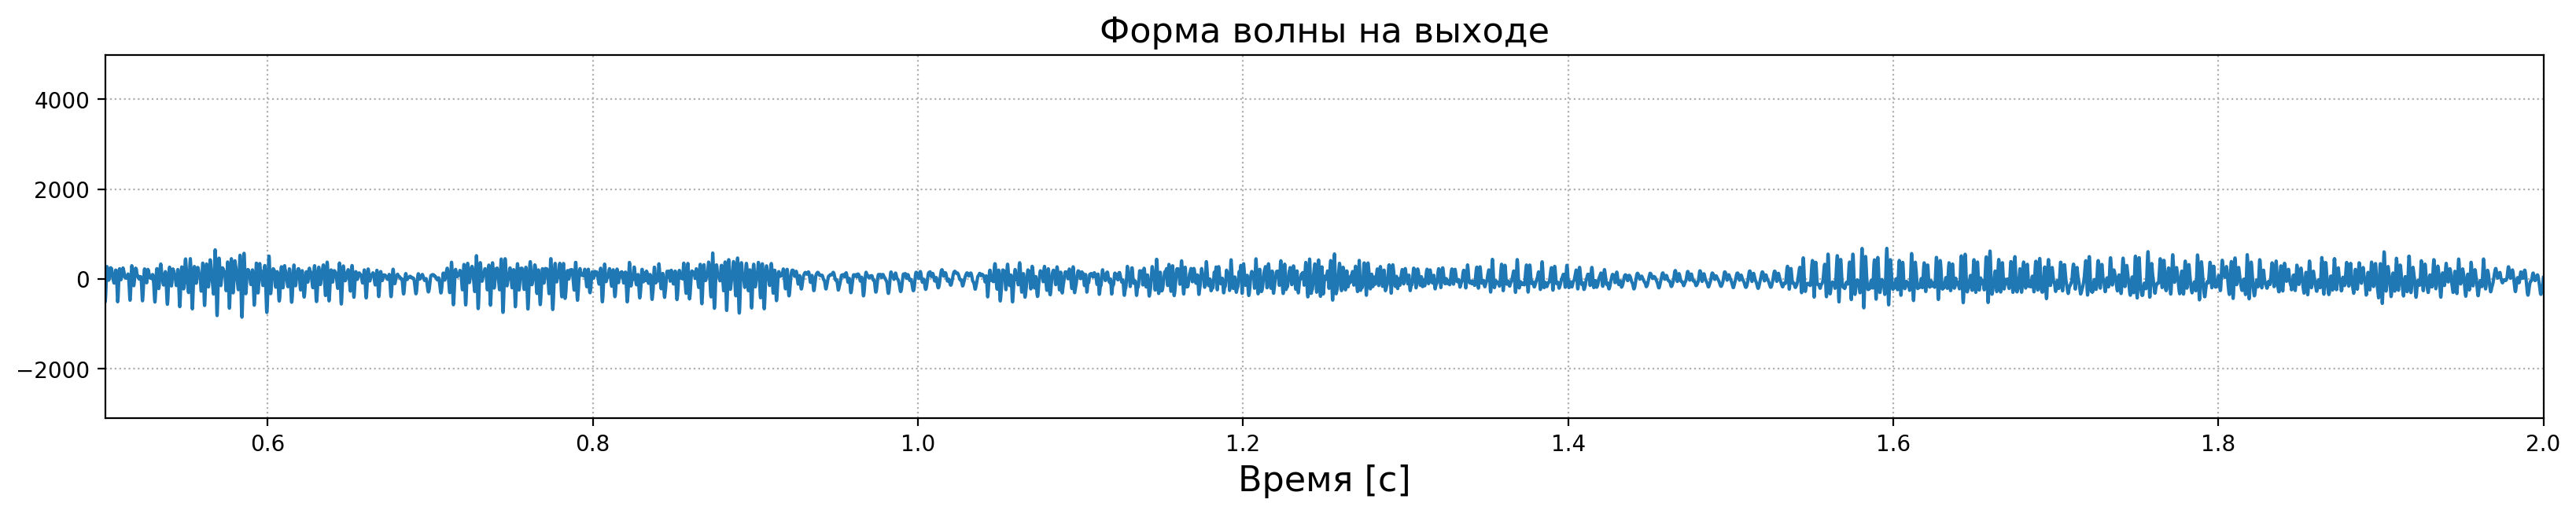

In [102]:
wavfile.write("result_2_lower.wav", sample_rate, (result * 2).astype(np.int16))


plt.figure(figsize = (20, 3), dpi = 200)
plt.plot(time, result)
plt.grid(ls = ':')
plt.xlabel("Время [c]", fontsize = 16)
plt.title("Форма волны на выходе", fontsize = 16)
plt.xlim(left_lim, right_lim);

In [103]:
display.Audio(r"result_2_lower.wav")

## Дополнение

### Пусть осцилляторы будут затюнены под несущую частоту голоса.

### Спектрограмма исходного сигнала

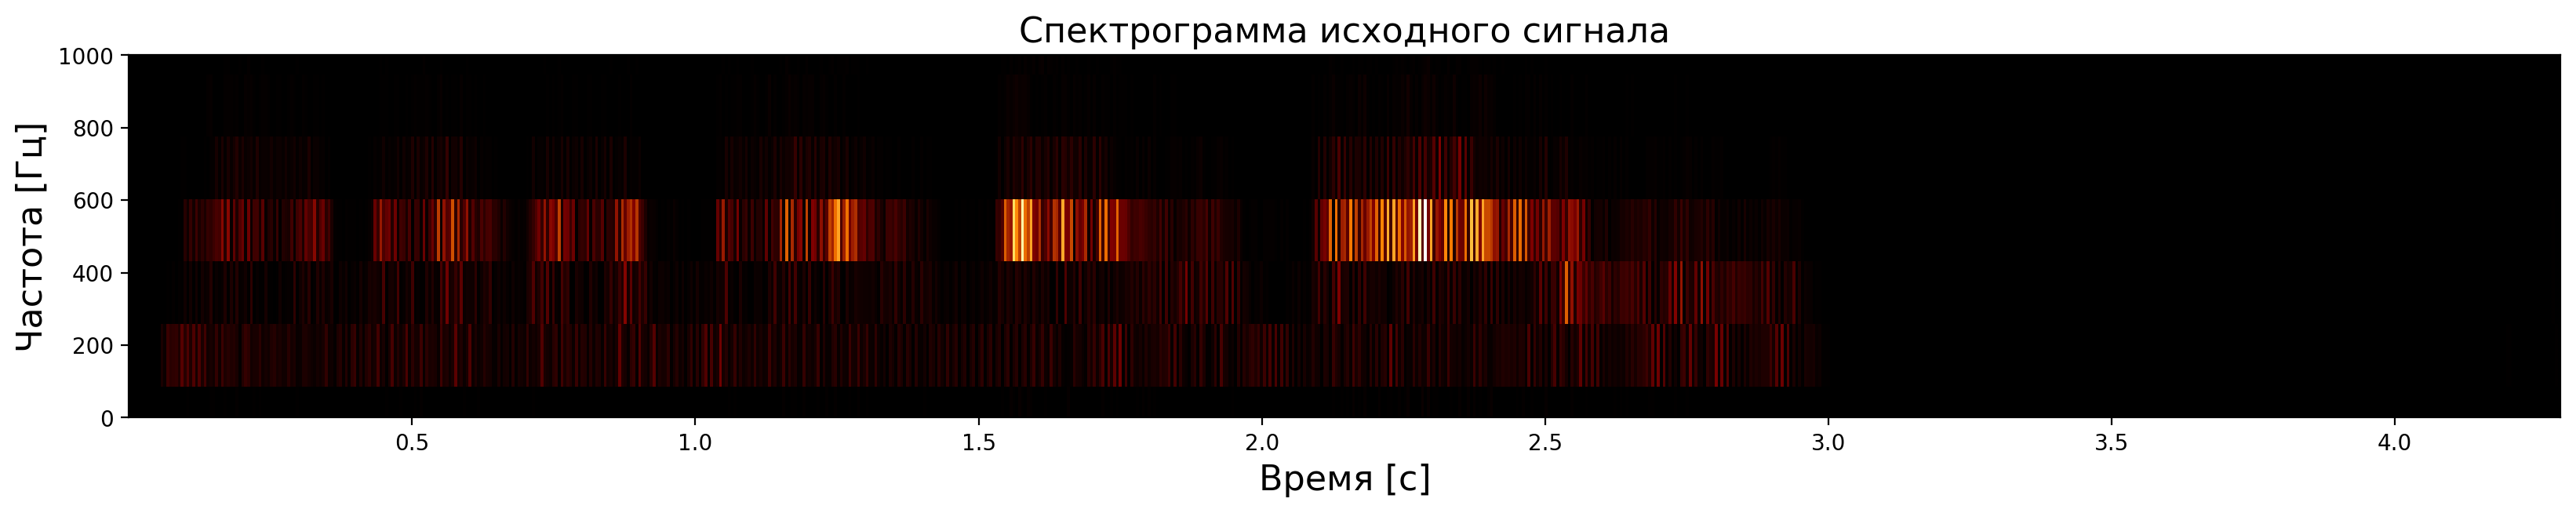

In [104]:
voice_freq, voice_t, voice_sxx = signal.spectrogram(voice, fs = sample_rate)

plt.figure(figsize = (20, 3), dpi = 200)
im = plt.pcolormesh(voice_t, voice_freq, voice_sxx, cmap = 'afmhot')

plt.ylim(0, 1000)
plt.xlabel("Время [c]", fontsize = 16)
plt.ylabel("Частота [Гц]", fontsize = 16)
plt.title("Спектрограмма исходного сигнала", fontsize = 16);

Найдем частоты с максимальной амплитудой в исходном сигнале - голосе.

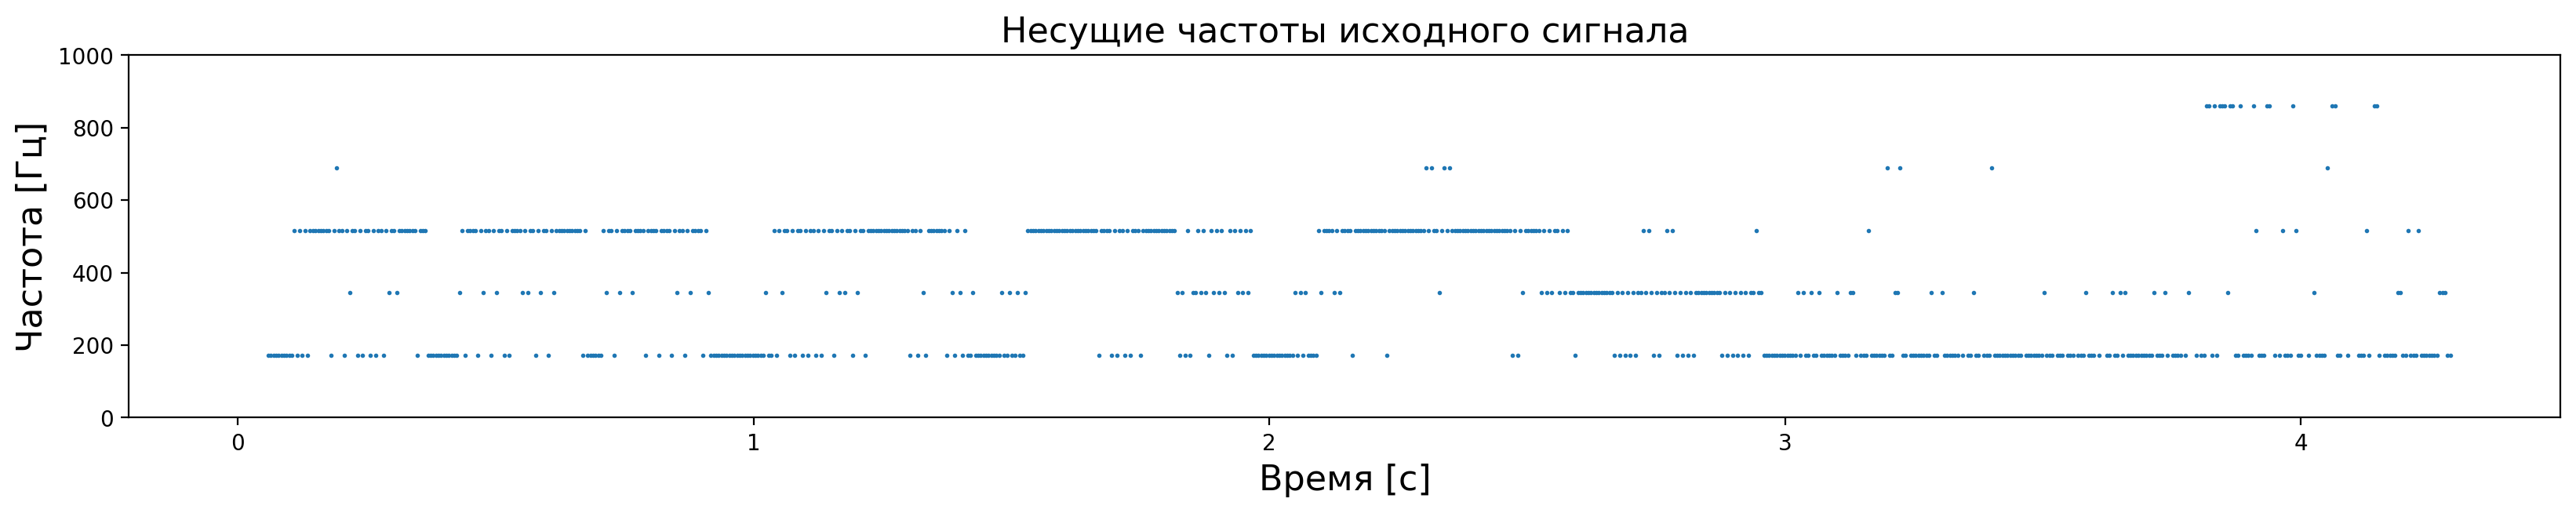

In [105]:
loudest_harmonic = voice_freq[np.argmax(voice_sxx, axis = 0)]

plt.figure(figsize = (20, 3), dpi = 200)
plt.scatter(voice_t, loudest_harmonic, s = 1)

plt.ylim(0, 1000)
plt.xlabel("Время [c]", fontsize = 16)
plt.ylabel("Частота [Гц]", fontsize = 16)
plt.title("Несущие частоты исходного сигнала", fontsize = 16);

### Создадим генератор, который следует за частотой на голосе и квантуется к ближайше <<музыкальной>> частоте

In [106]:
note_frequencies = {
    "C": [16.35, 32.70, 65.41, 130.81, 261.63, 523.25, 1046.50, 2093.00, 4186.01],
   "Db":   [17.32, 34.65, 69.30, 138.59, 277.18, 554.37, 1108.73, 2217.46, 4434.92],
    "D":   [18.35, 36.71, 73.42, 146.83, 293.66, 587.33, 1174.66, 2349.32, 4698.64],
   "Eb":   [19.45, 38.89, 77.78, 155.56, 311.13, 622.25, 1244.51, 2489.02, 4978.03],
    "E":   [20.60, 41.20, 82.41, 164.81, 329.63, 659.26, 1318.51, 2637.02],
    "F":   [21.83, 43.65, 87.31, 174.61, 349.23, 698.46, 1396.91, 2793.83],
   "Gb":   [23.12, 46.25, 92.50, 185.00, 369.99, 739.99, 1479.98, 2959.96],
    "G":   [24.50, 49.00, 98.00, 196.00, 392.00, 783.99, 1567.98, 3135.96],
   "Ab":   [25.96, 51.91, 103.83, 207.65, 415.30, 830.61, 1661.22, 3322.44],
    "A":   [27.50, 55.00, 110.00, 220.00, 440.00, 880.00, 1760.00, 3520.00],
   "Bb":   [29.14, 58.27, 116.54, 233.08, 466.16, 932.33, 1864.66, 3729.31],
    "B":   [30.87, 61.74, 123.47, 246.94, 493.88, 987.77, 1975.53, 3951.07]
 }
chromatic_scale = np.hstack([np.array(note_frequencies[key]) for key in note_frequencies.keys()])

def quant_chromatic(freq: float) -> float:
    delta = np.abs(chromatic_scale - freq)
    return chromatic_scale[np.argmin(delta)]

Text(0.5, 1.0, 'Квантованный генератор сигналов')

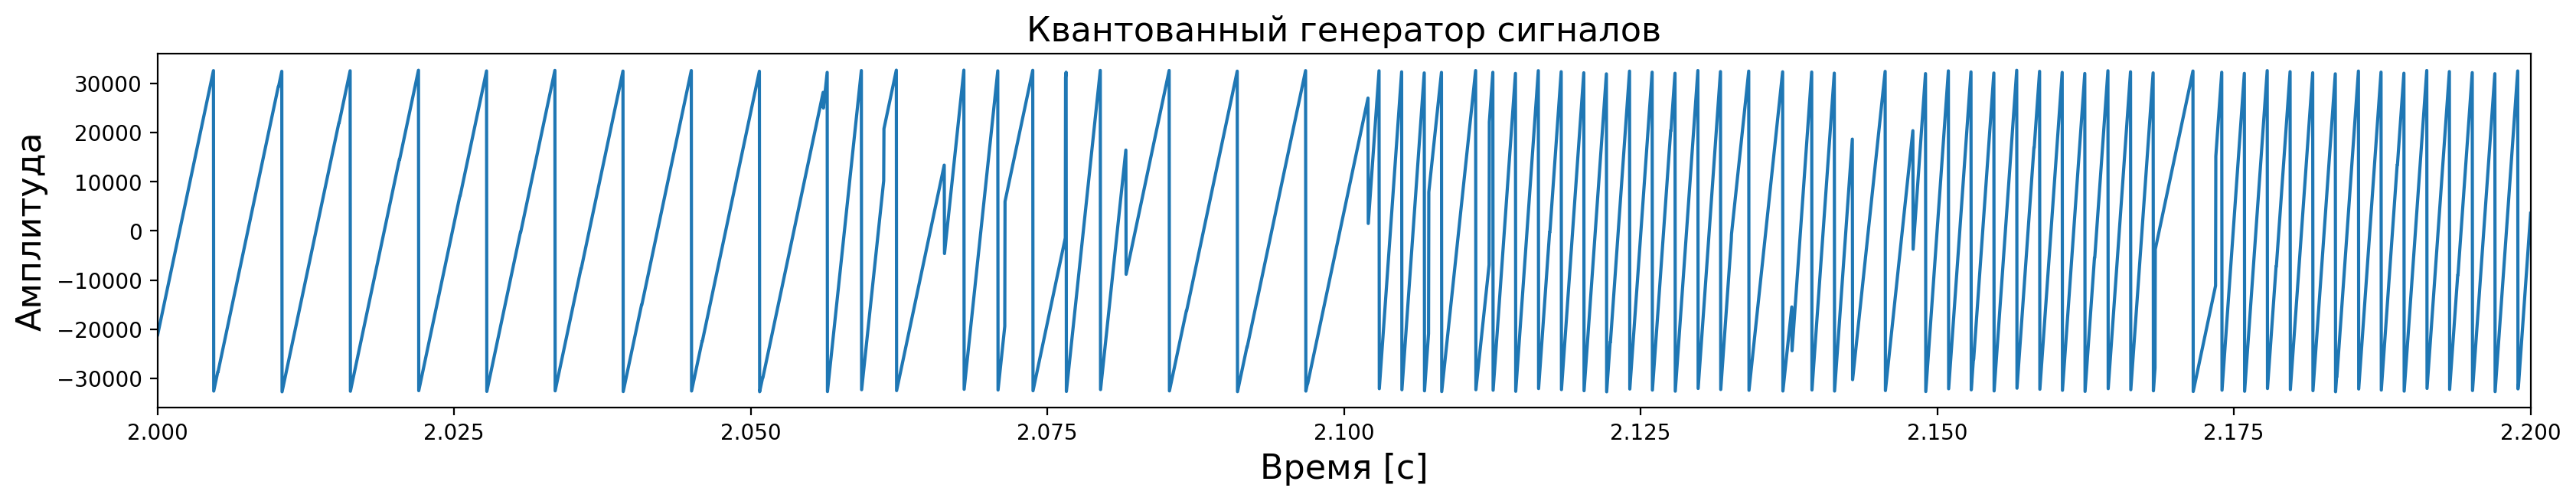

In [107]:
measured_times = [np.linspace(voice_t[i], voice_t[i + 1], int(voice.shape[0] / voice_t.shape[0]) + 1) for i in range(len(voice_t) - 1)]

osc = np.hstack([signal.sawtooth(2 * np.pi * quant_chromatic(freq) * t) for freq, t in zip(loudest_harmonic, measured_times)])
osc = max_amplitude * osc[:time.shape[0]]

plt.figure(figsize = (20, 3), dpi = 200)
plt.plot(time, osc)
plt.xlim(2, 2.2)
plt.xlabel("Время [c]", fontsize = 16)
plt.ylabel("Амплитуда", fontsize = 16)
plt.title("Квантованный генератор сигналов", fontsize = 16)

(0.0, 1000.0)

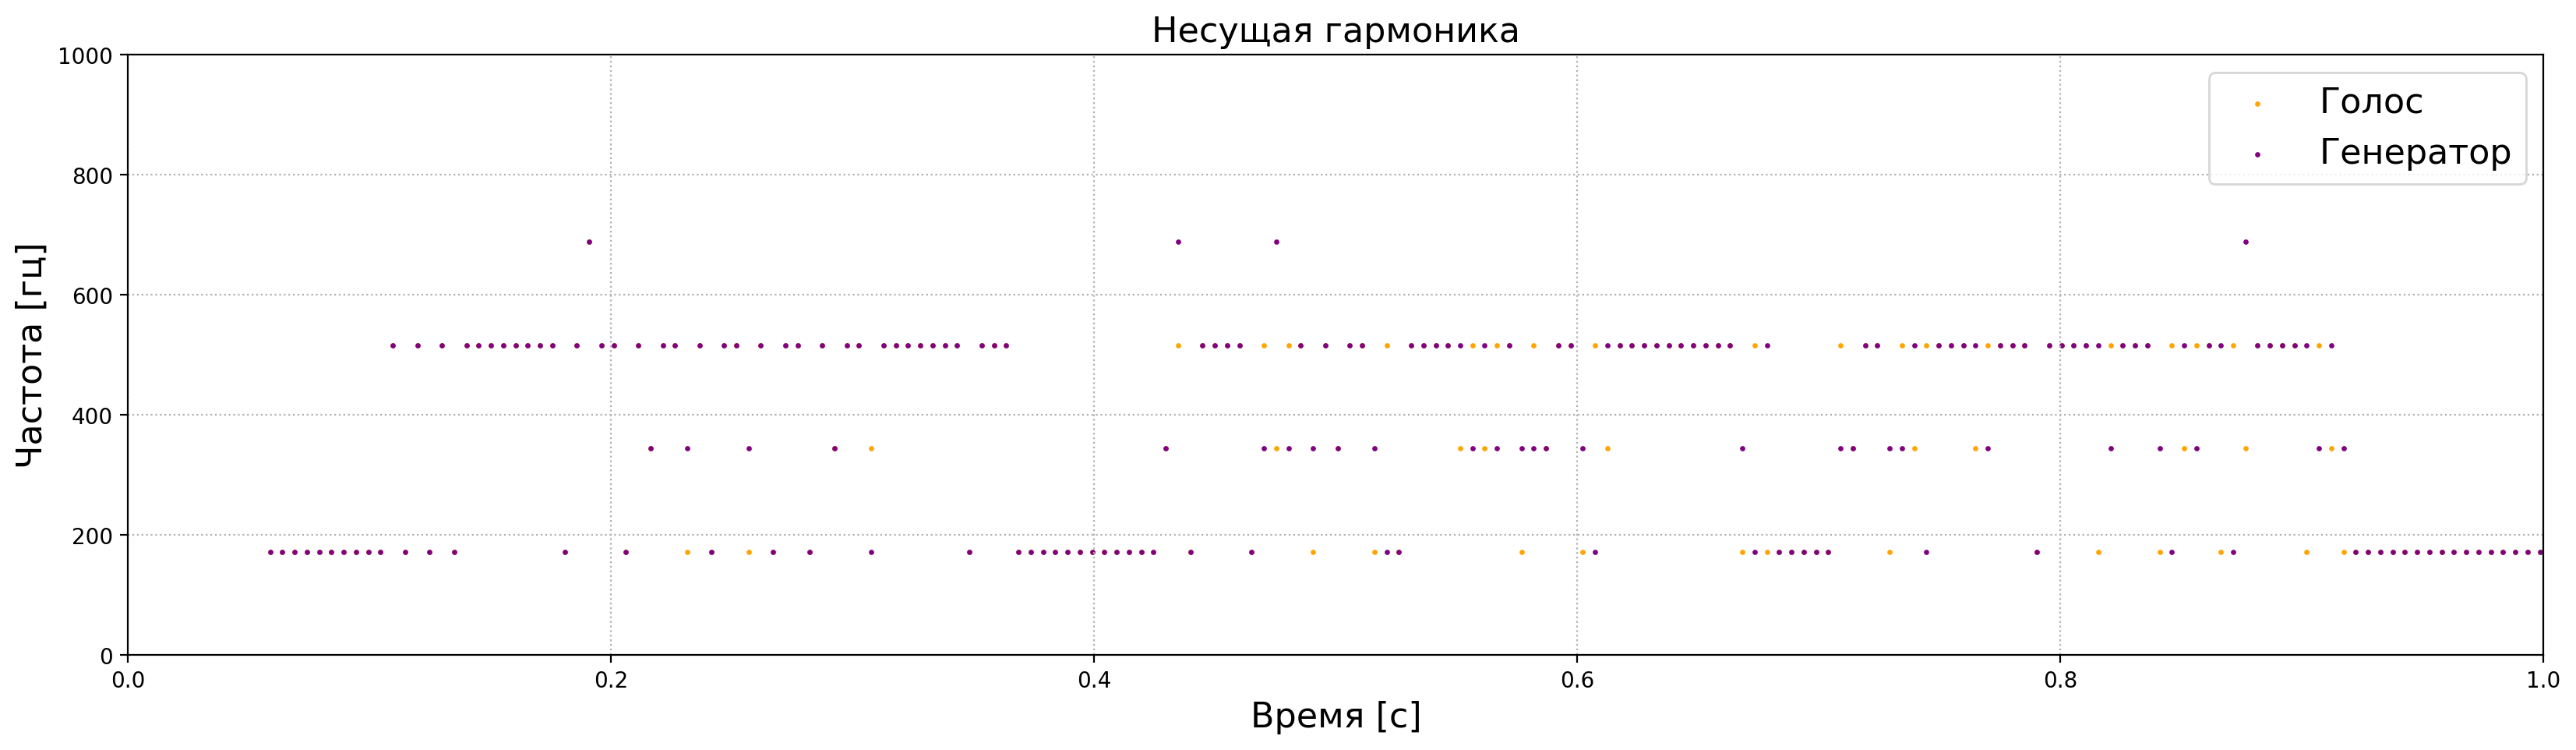

In [115]:
plt.figure(figsize = (20, 5), dpi = 200)

osc_freq, osc_t, osc_sxx = signal.spectrogram(osc, fs = sample_rate)
loudest_harmonic_osc = osc_freq[np.argmax(osc_sxx, axis = 0)]

plt.scatter(voice_t, loudest_harmonic, s = 2, color = 'orange', label = 'Голос')
plt.scatter(osc_t, loudest_harmonic_osc, s = 2, color = 'purple', label = 'Генератор')
plt.legend(fontsize = 16)
plt.xlabel("Время [c]", fontsize = 16)
plt.ylabel("Частота [гц]", fontsize = 16)
plt.title("Несущая гармоника", fontsize = 16)
plt.grid(ls = ':')
plt.xlim(0, 1)
plt.ylim(0, 1000)

#### Отфильтруем сигнал с генератора

In [109]:
carrier_filtered = [signal.sosfilt(bp_filters[i], osc) for i in range(len(center_freqs))]
carrier_filtered_amplifiered = [sig * env / amplitude_osc for env, sig in zip(filtered_signals_envelope, carrier_filtered)]
result = sum(carrier_filtered_amplifiered)

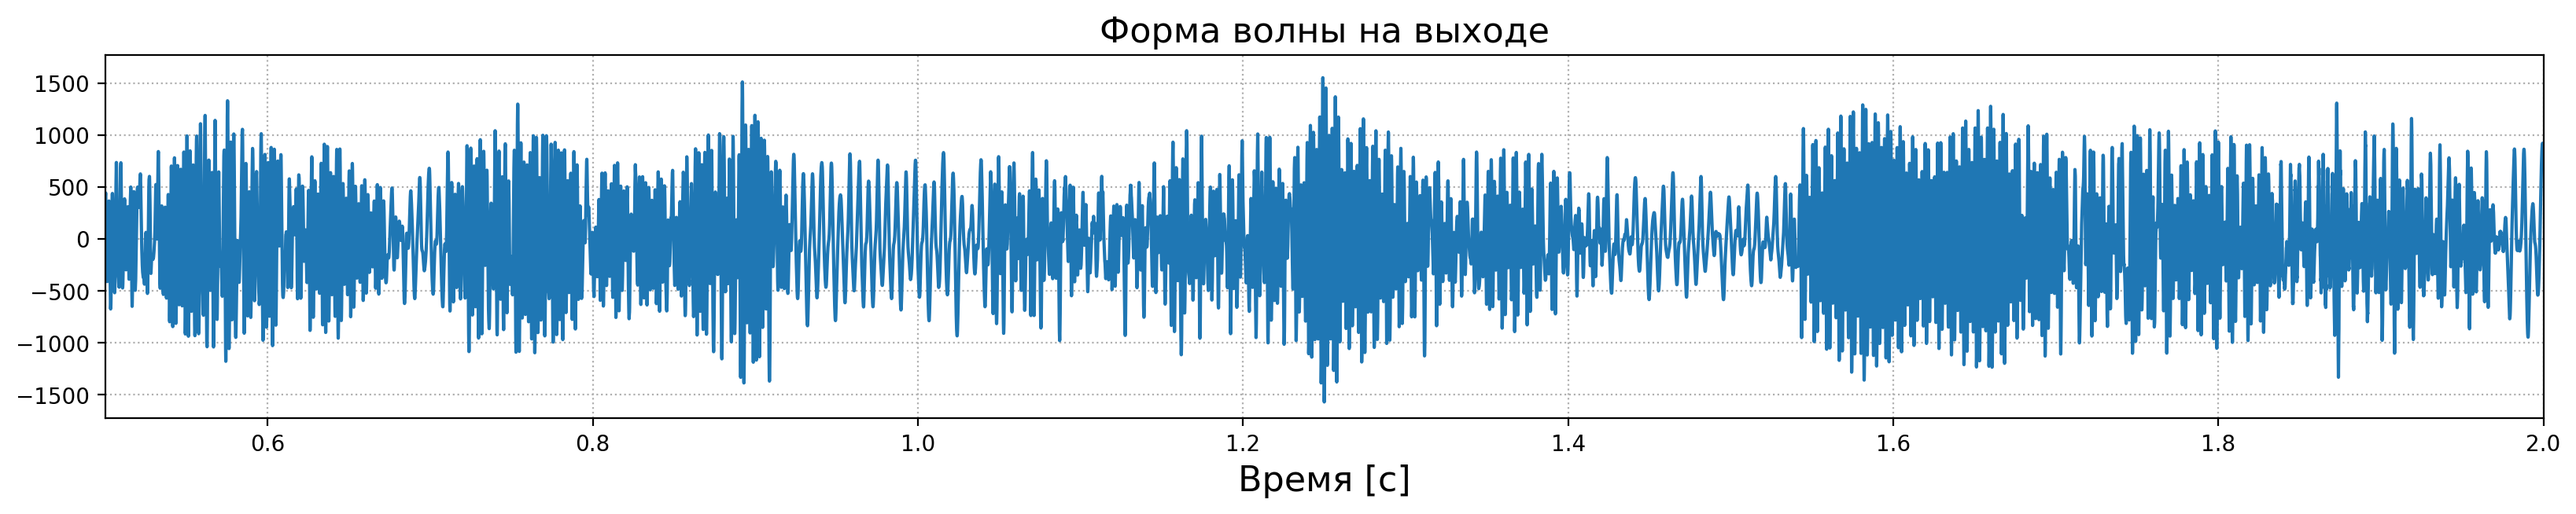

In [110]:
wavfile.write("result_quant.wav", sample_rate, (result * 2).astype(np.int16))


plt.figure(figsize = (20, 3), dpi = 200)
plt.plot(time, result)
plt.grid(ls = ':')
plt.xlabel("Время [c]", fontsize = 16)
plt.title("Форма волны на выходе", fontsize = 16)
plt.xlim(left_lim, right_lim);

In [111]:
display.Audio(r"result_quant.wav")